# QII Processing]
Inspired from
https://github.com/cmu-transparency/tool-qii/blob/master/qii_lite/lendingclub_chargeoff_clustering.ipynb

## 1. Download PUMA Data

In [ ]:
!wget https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pus.zip

--2021-12-03 03:09:30--  https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pus.zip
Resolving www2.census.gov (www2.census.gov)... 104.65.189.211, 2600:1409:5000:48c::208c, 2600:1409:5000:48d::208c
Connecting to www2.census.gov (www2.census.gov)|104.65.189.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘csv_pus.zip’

csv_pus.zip             [      <=>           ] 541.54M   108MB/s    in 5.6s    

2021-12-03 03:09:36 (97.5 MB/s) - ‘csv_pus.zip’ saved [567851237]



In [ ]:
# unzip data
!unzip csv_pus.zip

Archive:  csv_pus.zip
  inflating: psam_pusa.csv           
  inflating: psam_pusb.csv           
  inflating: ACS2019_PUMS_README.pdf  


##2. Data Display (pusa)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [ ]:
pusa = pd.read_csv('psam_pusa.csv')  

In [ ]:
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))

The shape of PUSA is (1658808, 288)
Memory : 3821 Mb


In [ ]:
# display data
pusa.head(2)

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,...,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2019GQ0000088,6,1,2200,3,1,1010145,11,39,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,1,2,2,2,0.0,NaN,NaN,NaN,2.0,5,...,1,9,10,12,22,12,0,12,0,0,22,10,21,11,12,20,11,21,1,10,0,9,11,11,22,12,2,9,2,2,22,10,20,13,10,21,12,22,0,10
1,P,2019GQ0000096,6,1,1000,3,1,1010145,70,21,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,0,2,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,...,64,72,128,63,72,13,9,130,118,10,65,124,10,9,64,66,136,71,70,70,76,68,122,74,73,11,11,139,115,10,67,131,11,10,73,71,128,76,82,69


## 3. Data Cleaning

### Remove rows with age < 16

In [ ]:
pusa = pusa.drop(pusa[pusa['AGEP']<16].index) 
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))

The shape of PUSA is (1374953, 288)
Memory : 3178 Mb


### Remove columns with more than 60% null values

In [ ]:
check_null = pusa.isnull().sum(axis=0).sort_values(ascending=False)/float(len(pusa))
check_null[check_null>0.6]

GCM          0.991320
DRAT         0.981015
SFN          0.978200
SFR          0.978200
NOP          0.974252
ESP          0.974252
GCR          0.973551
FHINS5C      0.966009
FOD2P        0.965167
MLPA         0.921413
MLPK         0.921413
MLPJ         0.921413
VPS          0.921413
MLPB         0.921413
MLPH         0.921413
MLPFG        0.921413
MLPE         0.921413
MLPCD        0.921413
MLPI         0.921413
CITWP        0.909473
DRATX        0.908339
SCHG         0.882954
MIGSP        0.870504
MIGPUMA      0.870504
FHINS4C      0.841857
YOEP         0.831254
DECADE       0.831254
ENG          0.799126
LANP         0.799126
FER          0.750655
FHINS3C      0.725782
SCIENGRLP    0.686639
FOD1P        0.686639
SCIENGP      0.686639
dtype: float64

In [ ]:
len(check_null[check_null==0])

227

In [ ]:
pusa.drop(check_null[check_null>0.6].index, axis=1, inplace=True) 
pusa.dropna(axis=0, thresh=30, inplace=True)

In [ ]:
# After drop null column 
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))

The shape of PUSA is (1374953, 254)
Memory : 2804 Mb


### Remove income related features

In [ ]:
# pusa.drop(['INTP', 'OIP', 'PAP', 'RETP', 'SEMP', 'SSIP', 'SSP', 'WAGP', 'PERNP', 'PINCP'], axis=1, inplace=True)
pusa.drop(['INTP', 'OIP', 'PAP', 'RETP', 'SEMP', 'SSIP', 'SSP', 'WAGP', 'PERNP'], axis=1, inplace=True)
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))  

The shape of PUSA is (1374953, 245)
Memory : 2705 Mb


### Remove columns with little information

In [ ]:
print('RT contain information?')
print(len(pusa[pusa['RT']=='P'])/len(pusa)) #1.0 drop RT
pusa.drop(['RT', 'SERIALNO'], axis=1, inplace=True) # drop SERIALNO

RT contain information?
1.0


In [ ]:
pusa.head(10)

,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DREM,GCL,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,JWMNP,JWRIP,JWTRNS,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,NWAB,NWAV,NWLA,...,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,6,1,2200,3,1,1010145,11,39,1,NaN,2.0,2,2,2.0,2.0,1.0,2.0,0,2,2,1,1,2,2,2,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2.0,5.0,2.0,...,1,9,10,12,22,12,0,12,0,0,22,10,21,11,12,20,11,21,1,10,0,9,11,11,22,12,2,9,2,2,22,10,20,13,10,21,12,22,0,10
1,6,1,1000,3,1,1010145,70,21,1,NaN,2.0,2,2,2.0,2.0,2.0,NaN,0,2,2,2,2,2,2,2,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.0,5.0,3.0,...,64,72,128,63,72,13,9,130,118,10,65,124,10,9,64,66,136,71,70,70,76,68,122,74,73,11,11,139,115,10,67,131,11,10,73,71,128,76,82,69
2,6,1,1100,3,1,1010145,20,19,1,2.0,2.0,2,2,2.0,2.0,2.0,NaN,0,1,2,2,2,2,2,2,75.0,1.0,1.0,2.0,5,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.0,5.0,3.0,...,21,21,21,3,2,45,2,21,21,40,38,43,22,22,2,42,20,1,23,41,1,39,42,19,22,22,21,3,38,21,20,19,1,43,23,22,1,22,2,21
3,6,1,1100,3,1,1010145,79,77,1,NaN,1.0,2,2,1.0,1.0,1.0,2.0,1,2,1,1,2,2,2,2,NaN,NaN,NaN,2.0,2,2.0,2.0,1.0,2.0,1959.0,3.0,4.0,3.0,5.0,3.0,...,6,151,77,161,80,83,163,76,162,5,7,80,81,76,154,80,7,80,6,78,158,7,73,7,78,76,6,76,5,152,156,83,79,76,5,80,159,81,157,82
4,6,1,2701,3,1,1010145,53,41,1,NaN,2.0,2,2,2.0,2.0,2.0,2.0,0,2,2,2,2,2,2,2,NaN,NaN,NaN,2.0,4,2.0,2.0,1.0,2.0,2011.0,3.0,4.0,3.0,5.0,3.0,...,94,55,9,100,104,59,51,8,52,55,52,53,8,52,51,94,92,8,8,9,54,97,53,51,56,10,8,55,8,105,8,96,54,98,104,52,53,53,57,9
5,6,1,2000,3,1,1010145,77,18,1,NaN,2.0,2,2,2.0,2.0,2.0,NaN,0,1,2,2,2,2,2,2,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,3.0,4.0,2.0,5.0,2.0,...,5,152,5,7,77,84,149,153,7,75,75,81,7,79,70,80,143,75,81,6,146,5,150,144,79,78,7,6,142,78,72,73,149,82,82,79,7,77,73,7
6,6,1,2702,3,1,1010145,8,93,1,NaN,1.0,2,2,1.0,1.0,1.0,2.0,0,2,2,1,1,2,2,2,NaN,NaN,NaN,2.0,2,2.0,2.0,1.0,2.0,1979.0,1.0,4.0,3.0,5.0,3.0,...,16,8,15,1,9,10,9,0,8,17,8,1,1,8,8,0,16,10,16,8,18,9,17,1,8,8,9,0,8,17,10,1,0,8,8,2,17,9,16,8
7,6,1,1400,3,1,1010145,15,35,1,NaN,2.0,2,2,2.0,2.0,1.0,2.0,0,2,2,2,1,2,2,2,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2.0,5.0,2.0,...,28,13,2,29,30,2,15,15,2,16,0,15,15,15,26,14,32,14,15,1,30,14,2,29,29,2,15,14,2,16,1,14,14,16,29,14,30,15,14,26
8,6,1,2100,3,1,1010145,61,39,1,4.0,2.0,2,2,2.0,2.0,1.0,2.0,0,2,2,2,2,2,2,2,NaN,NaN,NaN,2.0,3,2.0,2.0,1.0,2.0,2003.0,1.0,4.0,3.0,5.0,3.0,...,104,62,9,55,62,10,58,113,103,110,58,58,58,59,57,8,10,9,60,115,121,60,9,65,64,9,68,121,101,114,58,60,63,60,63,10,9,10,72,8
9,6,1,1302,3,1,1010145,152,18,1,NaN,2.0,2,2,2.0,2.0,2.0,NaN,0,1,2,2,2,2,2,2,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.0,5.0,3.0,...,148,159,12,12,288,13,162,156,298,289,283,160,158,14,277,159,14,156,163,281,294,277,157,152,155,154,12,292,152,153,143,12,313,160,149,11,148,12,12,155


### Remove non-information flags

In [ ]:
# all flags
# flags = ['FAGEP','FANCP','FCITP','FCITWP','FCOWP','FDDRSP','FDEARP','FDEYEP','FDISP','FDOUTP','FDPHYP','FDRATP','FDRATXP','FDREMP','FENGP','FESRP','FFERP','FFODP','FGCLP','FGCMP','FGCRP','FHICOVP','FHIMRKSP','FHINS1P','FHINS2P','FHINS3C','FHINS3P','FHINS4C','FHINS4P','FHINS5C','FHINS5P','FHINS6P','FHINS7P','FHISP','FINDP','FINTP','FJWDP','FJWMNP','FJWRIP','FJWTRNSP','FLANP','FLANXP','FMARP','FMARHDP','FMARHMP','FMARHTP','FMARHWP','FMARHYP','FMIGP','FMIGSP','FMILPP','FMILSP','FOCCP','FOIP','FPAP','FPERNP','FPINCP','FPOBP','FPOWSP','FPRIVCOVP','FPUBCOVP','FRACP','FRELSHIPP','FRETP','FSCHGP','FSCHLP','FSCHP','FSEMP','FSEXP','FSSIP','FSSP','FWAGP','FWKHP','FWKLP','FWKWNP','FWRKP','FYOEP']

In [ ]:
print(f'FAGEP',len(pusa[pusa['FAGEP']==0])/len(pusa))
print(f'FANCP',len(pusa[pusa['FANCP']==0])/len(pusa))
print(f'FCITP',len(pusa[pusa['FCITP']==0])/len(pusa))
print(f'FCITWP',len(pusa[pusa['FCITWP']==0])/len(pusa))

print(f'FCOWP',len(pusa[pusa['FCOWP']==0])/len(pusa))
print(f'FDDRSP',len(pusa[pusa['FDDRSP']==0])/len(pusa))
print(f'FDEARP',len(pusa[pusa['FDEARP']==0])/len(pusa))
print(f'FDEYEP',len(pusa[pusa['FDEYEP']==0])/len(pusa))
print(f'FDISP',len(pusa[pusa['FDISP']==0])/len(pusa))

print(f'FDOUTP',len(pusa[pusa['FDOUTP']==0])/len(pusa))
print(f'FDPHYP',len(pusa[pusa['FDPHYP']==0])/len(pusa))
print(f'FDRATP',len(pusa[pusa['FDRATP']==0])/len(pusa))
print(f'FDRATXP',len(pusa[pusa['FDRATXP']==0])/len(pusa))
print(f'FDREMP',len(pusa[pusa['FDREMP']==0])/len(pusa))

print(f'FENGP',len(pusa[pusa['FENGP']==0])/len(pusa))
print(f'FESRP',len(pusa[pusa['FESRP']==0])/len(pusa))
print(f'FFERP',len(pusa[pusa['FFERP']==0])/len(pusa))
print(f'FFODP',len(pusa[pusa['FFODP']==0])/len(pusa))
print(f'FGCLP',len(pusa[pusa['FGCLP']==0])/len(pusa))

print(f'FGCMP',len(pusa[pusa['FGCMP']==0])/len(pusa))
print(f'FGCRP',len(pusa[pusa['FGCRP']==0])/len(pusa))
print(f'FHICOVP',len(pusa[pusa['FHICOVP']==0])/len(pusa))
print(f'FHIMRKSP',len(pusa[pusa['FHIMRKSP']==0])/len(pusa))
print(f'FHINS1P',len(pusa[pusa['FHINS1P']==0])/len(pusa))

print(f'FHINS2P',len(pusa[pusa['FHINS2P']==0])/len(pusa))
print(f'FHINS3P',len(pusa[pusa['FHINS3P']==0])/len(pusa))
print(f'FHINS4P',len(pusa[pusa['FHINS4P']==0])/len(pusa))
print(f'FHINS5P',len(pusa[pusa['FHINS5P']==0])/len(pusa))
print(f'FHINS6P',len(pusa[pusa['FHINS6P']==0])/len(pusa))

print(f'FHINS7P',len(pusa[pusa['FHINS7P']==0])/len(pusa))
print(f'FHISP',len(pusa[pusa['FHISP']==0])/len(pusa))
print(f'FINDP',len(pusa[pusa['FINDP']==0])/len(pusa))
print(f'FINTP',len(pusa[pusa['FINTP']==0])/len(pusa))
print(f'FJWDP',len(pusa[pusa['FJWDP']==0])/len(pusa))

print(f'FJWMNP',len(pusa[pusa['FJWMNP']==0])/len(pusa))
print(f'FJWRIP',len(pusa[pusa['FJWRIP']==0])/len(pusa))
print(f'FJWTRNSP',len(pusa[pusa['FJWTRNSP']==0])/len(pusa))
print(f'FLANP',len(pusa[pusa['FLANP']==0])/len(pusa))
print(f'FLANXP',len(pusa[pusa['FLANXP']==0])/len(pusa))

print(f'FMARP',len(pusa[pusa['FMARP']==0])/len(pusa))
print(f'FMARHDP',len(pusa[pusa['FMARHDP']==0])/len(pusa))
print(f'FMARHMP',len(pusa[pusa['FMARHMP']==0])/len(pusa))
print(f'FMARHTP',len(pusa[pusa['FMARHTP']==0])/len(pusa))
print(f'FMARHWP',len(pusa[pusa['FMARHWP']==0])/len(pusa))

print(f'FMARHYP',len(pusa[pusa['FMARHYP']==0])/len(pusa))
print(f'FMIGP',len(pusa[pusa['FMIGP']==0])/len(pusa))
print(f'FMIGSP',len(pusa[pusa['FMIGSP']==0])/len(pusa))
print(f'FMILPP',len(pusa[pusa['FMILPP']==0])/len(pusa))
print(f'FMILSP',len(pusa[pusa['FMILSP']==0])/len(pusa))

print(f'FOCCP',len(pusa[pusa['FOCCP']==0])/len(pusa))
print(f'FOIP',len(pusa[pusa['FOIP']==0])/len(pusa))
print(f'FPAP',len(pusa[pusa['FPAP']==0])/len(pusa))
print(f'FPERNP',len(pusa[pusa['FPERNP']==0])/len(pusa))
print(f'FPINCP',len(pusa[pusa['FPINCP']==0])/len(pusa))

print(f'FPOBP',len(pusa[pusa['FPOBP']==0])/len(pusa))
print(f'FPOWSP',len(pusa[pusa['FPOWSP']==0])/len(pusa))
print(f'FPRIVCOVP',len(pusa[pusa['FPRIVCOVP']==0])/len(pusa))
print(f'FPUBCOVP',len(pusa[pusa['FPUBCOVP']==0])/len(pusa))
print(f'FRACP',len(pusa[pusa['FRACP']==0])/len(pusa))

print(f'FRELSHIPP',len(pusa[pusa['FRELSHIPP']==0])/len(pusa))
print(f'FRETP',len(pusa[pusa['FRETP']==0])/len(pusa))
print(f'FSCHGP',len(pusa[pusa['FSCHGP']==0])/len(pusa))
print(f'FSCHLP',len(pusa[pusa['FSCHLP']==0])/len(pusa))
print(f'FSCHP',len(pusa[pusa['FSCHP']==0])/len(pusa))

print(f'FSEMP',len(pusa[pusa['FSEMP']==0])/len(pusa))
print(f'FSEXP',len(pusa[pusa['FSEXP']==0])/len(pusa))
print(f'FSSIP',len(pusa[pusa['FSSIP']==0])/len(pusa))
print(f'FSSP',len(pusa[pusa['FSSP']==0])/len(pusa))
print(f'FWAGP',len(pusa[pusa['FWAGP']==0])/len(pusa))

print(f'FWKHP',len(pusa[pusa['FWKHP']==0])/len(pusa))
print(f'FWKLP',len(pusa[pusa['FWKLP']==0])/len(pusa))
print(f'FWKWNP',len(pusa[pusa['FWKWNP']==0])/len(pusa))
print(f'FWRKP',len(pusa[pusa['FWRKP']==0])/len(pusa))
print(f'FYOEP',len(pusa[pusa['FYOEP']==0])/len(pusa))

FAGEP 0.9877384899702026
FANCP 1.0
FCITP 0.931578752146437
FCITWP 0.9799847703885151
FCOWP 0.8991856448911345
FDDRSP 0.9125344648144337
FDEARP 0.919256149119279
FDEYEP 0.9168386119380081
FDISP 0.8922261342751352
FDOUTP 0.9120733581438784
FDPHYP 0.9128079287073813
FDRATP 0.9997418093563926
FDRATXP 0.9938768816097714
FDREMP 0.9134566781555442
FENGP 0.9802211421044937
FESRP 0.8968233823265231
FFERP 0.975274791211045
FFODP 0.9564785123564223
FGCLP 0.9961416862976408
FGCMP 0.9985846788944786
FGCRP 0.995967862174198
FHICOVP 0.8065395689889037
FHIMRKSP 0.9476694839750887
FHINS1P 0.8637349785774495
FHINS2P 0.8555412439552479
FHINS3P 0.8897416857158027
FHINS4P 0.8341572402838497
FHINS5P 0.8295330822217196
FHINS6P 0.8317753406843725
FHINS7P 0.8217822718303825
FHISP 0.9783672605536334
FINDP 0.8907642661240057
FINTP 0.8256507676989686
FJWDP 0.8780081937346222
FJWMNP 0.9140676081291506
FJWRIP 0.9344333951778715
FJWTRNSP 0.9340610188130067
FLANP 0.9775468688747906
FLANXP 0.9223311633197644
FMARP 0.9

In [ ]:
# drop > 99%
drop99 = ['FANCP', 'FDRATP', 'FDRATXP', 'FGCLP', 'FGCMP', 'FGCRP', 'FMILPP','FWRKP', 'FSEXP']
drop98 = ['FSCHGP', 'FRACP', 'FENGP', 'FAGEP']
pusa.drop(drop99, axis=1, inplace=True) # drop drop99

In [ ]:
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))  

The shape of PUSA is (1374953, 234)
Memory : 2584 Mb


### Remove Redundancy Flags

In [ ]:
redunflags = ['FYOEP', 'FWKHP', 'FWAGP', 'FSSP', 'FSSIP', 'FSEMP', 'FRETP' ,'FRELSHIPP', 'FPOWSP', 'FPOBP', 'FPINCP', 'FPERNP', 'FPAP', 'FOIP', 'FOCCP', 'FMIGSP', 'FMARHYP', 'FLANP', 'FJWRIP', 'FJWMNP', 'FJWDP','FINTP','FINDP','FHISP','FCITWP','FAGEP']
pusa.drop(redunflags, axis=1, inplace=True) 
print('The shape of PUSA is {}'.format(pusa.shape))
print('Memory : {} Mb'.format(int(pusa.memory_usage(deep=False).sum() / 1000000)))  

The shape of PUSA is (1374953, 208)
Memory : 2298 Mb


In [ ]:
print(pusa.shape)

(1374953, 208)


In [ ]:
# Drop any residual missing value 
pusana = pusa.copy()
pusana.dropna(axis=0, how = 'any', inplace = True)
print(pusana.shape)

(193550, 208)


In [ ]:
# drop string col
string_col = ['NAICSP', 'SOCP']
str_pusana = pusana[string_col]
str_pusana.head(100)
# NAICSP      Character   8 North American Industry Classification System (NAICS) recode for 2018 and later based on 2017 NAICS codes
# SOCP        Standard Occupational Classification

,NAICSP,SOCP
2387,928P,152031
2394,9211MP,439061
2399,8121M,395092
2404,62132,433021
2408,6211,291141
...,...,...
3166,3231,413091
3169,6111,252020
3200,6212,436014
3203,6111,259040


In [ ]:
pusana.drop(string_col, axis=1, inplace=True) 
print(pusana.shape)

(193550, 206)


In [ ]:
# one-hot encoding
# pusana = pd.get_dummies(pusana, columns=string_col).astype(float)

In [ ]:
# sample 10% data
pusa_sampled = pusana.copy()
pusa_sampled = pusana.sample(frac=0.1, random_state=11785)
print(pusa_sampled.shape)

(19355, 206)


In [ ]:
PINCP = []
PINCP = pusa_sampled[["PINCP"]]
pusa_sampled.drop(['PINCP'], axis=1, inplace=True)
print(pusa_sampled.shape)
print(PINCP.shape)

(19355, 205)
(19355, 1)


## Make PINCP clusters

make PINCP categorical? Yes



In [ ]:
PINCP.head(100)

,PINCP
1015183,31100.0
956734,56000.0
974050,26000.0
680246,73000.0
43732,19200.0
...,...
803530,48000.0
613411,108500.0
458259,50000.0
731406,48000.0


In [ ]:
# INCOME GROUP	          INCOME
# Low income	            Less than $40,100
# Middle income	          $41,000 - $120,400
# Upper income	          More than $120,400
PINCP.loc[: ,'PINCP_group'] = 0
print(PINCP.shape)
PINCP.head(100)
# mask1 = (PINCP.PINCP > 41000)
# PINCP.loc[mask1,'PINCP_group'] = 1

mask2 = (PINCP.PINCP > 120400)
PINCP.loc[mask2,'PINCP_group'] = 1

(19355, 2)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [ ]:
# PINCP = pd.get_dummies(PINCP, columns=['PINCP_group']).astype(float)
# PINCP.head(100)

,PINCP,PINCP_group_0,PINCP_group_1,PINCP_group_2
1015183,31100.0,1.0,0.0,0.0
956734,56000.0,0.0,1.0,0.0
974050,26000.0,1.0,0.0,0.0
680246,73000.0,0.0,1.0,0.0
43732,19200.0,1.0,0.0,0.0
...,...,...,...,...
803530,48000.0,0.0,1.0,0.0
613411,108500.0,0.0,1.0,0.0
458259,50000.0,0.0,1.0,0.0
731406,48000.0,0.0,1.0,0.0


## Model - Unbalanced

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

X_scaled = preprocessing.scale(pusa_sampled)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-1.0010529  -0.74175819 -0.71063406 ... -0.09536327 -0.82755248
  -0.35948418]
 [ 1.39738476  2.10313029 -0.90768394 ... -0.30328447 -0.38383989
  -0.86012936]
 [ 0.99764515  0.68068605 -0.87678067 ...  1.86503663  1.65320428
   0.87210294]
 ...
 [ 1.39738476  2.10313029  0.241386   ...  0.35018216 -0.10147733
  -0.73997452]
 [ 0.19816593  0.68068605 -0.94323932 ...  0.19176601  0.281729
   0.60175454]
 [-1.80053213  0.68068605 -0.37834085 ... -0.0260562  -0.37375552
  -0.82007774]]
   
(19355, 205)


In [ ]:
from xgboost import XGBClassifier
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    #clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 4, n_estimators=100, max_features = 0.3),
    #        'LogisticRegression' : LogisticRegression(),
    #        #'GaussianNB': GaussianNB(),
    #        'RandomForestClassifier': RandomForestClassifier(n_estimators=50),
    #        'XG Boost': XGBClassifier()
    #        }
    clfs = {#'GradientBoosting': GradientBoostingClassifier(max_depth= 4, n_estimators=100, max_features = 0.3),
            # 'LogisticRegression' : LogisticRegression(),
            # 'GaussianNB': GaussianNB(),
            # 'RandomForestClassifier': RandomForestClassifier(n_estimators=50),
            'XG Boost': XGBClassifier(),
            # 'XG Boost 1': XGBClassifier(subsample=0.5, objective='binary:logistic'),
            # 'XG Boost 2': XGBClassifier(n_estimators=50, objective='binary:logistic'),
            # 'XG Boost 3': XGBClassifier(subsample=0.5, n_estimators=50, objective='binary:logistic'),
            # 'XG Boost 4': XGBClassifier(subsample=0.4, n_estimators=75, objective='binary:logistic'),
            # 'XG Boost 5': XGBClassifier(subsample=0.5, n_estimators=50, min_child_weight=3, objective='binary:logistic'),
            # 'XG Boost 6': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, objective='binary:logistic'),
            # 'XG Boost 7': XGBClassifier(subsample=0.5, n_estimators=50, min_child_weight=3, max_depth=5, objective='binary:logistic'),
            # 'XG Boost 8': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, max_depth=7, objective='binary:logistic'),
            # 'XG Boost 9': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, max_depth=7, objective='binary:logistic')
           }
            
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    models_report_train = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        y_pred_train = clf.predict(X_train)
        y_score_train = clf.predict_proba(X_train)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp_test = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score), 
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        tmp_train = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_train, y_score_train), 
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_train, y_pred_train),
                         'precision_score': metrics.precision_score(y_train, y_pred_train),
                         'recall_score': metrics.recall_score(y_train, y_pred_train),
                         'f1_score': metrics.f1_score(y_train, y_pred_train)})

        models_report = models_report.append(tmp_test, ignore_index = True)
        models_report_train =  models_report_train.append(tmp_train, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return {'test' : models_report, 'train': models_report_train} , conf_matrix, clfs

In [ ]:
# y = PINCP[['PINCP_group_0', 'PINCP_group_1', 'PINCP_group_2']].to_numpy()
y = PINCP['PINCP_group'].to_numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


computing LogisticRegression - Non-balanced 
computing GaussianNB - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XG Boost - Non-balanced 
computing XG Boost 1 - Non-balanced 
computing XG Boost 2 - Non-balanced 
computing XG Boost 3 - Non-balanced 
computing XG Boost 4 - Non-balanced 
computing XG Boost 5 - Non-balanced 
computing XG Boost 6 - Non-balanced 
computing XG Boost 7 - Non-balanced 
computing XG Boost 8 - Non-balanced 
computing XG Boost 9 - Non-balanced 


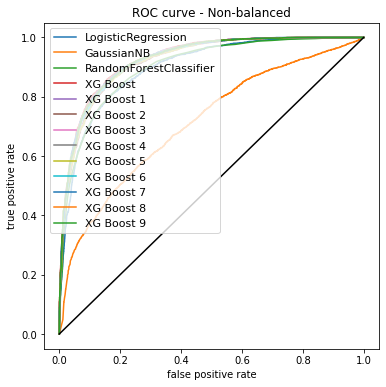

In [ ]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix, clfs = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

In [ ]:
models_report['train']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.651286,0.907517,0.818539,0.856071,0.836884,Non-balanced
1,GaussianNB,0.295078,0.720463,0.625747,0.800028,0.702236,Non-balanced
2,RandomForestClassifier,0.999852,1.000000,0.999858,1.000000,0.999929,Non-balanced
3,XG Boost,0.720875,0.936413,0.856435,0.880555,0.868327,Non-balanced
4,XG Boost 1,0.715840,0.936532,0.853998,0.878290,0.865974,Non-balanced
5,XG Boost 2,0.682682,0.924038,0.833876,0.869516,0.851323,Non-balanced
6,XG Boost 3,0.683583,0.923542,0.837512,0.865129,0.851096,Non-balanced
7,XG Boost 4,0.699065,0.930491,0.848091,0.867535,0.857703,Non-balanced
8,XG Boost 5,0.681673,0.923128,0.836115,0.864987,0.850306,Non-balanced
9,XG Boost 6,0.696839,0.930188,0.847582,0.865695,0.856543,Non-balanced


In [ ]:
models_report['test']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.628635,0.898442,0.807852,0.841983,0.824564,Non-balanced
1,GaussianNB,0.283274,0.712167,0.617367,0.797073,0.695804,Non-balanced
2,RandomForestClassifier,0.634987,0.901013,0.827227,0.818696,0.822939,Non-balanced
3,XG Boost,0.698648,0.928288,0.843428,0.870925,0.856956,Non-balanced
4,XG Boost 1,0.693121,0.926469,0.840851,0.868263,0.854337,Non-balanced
5,XG Boost 2,0.682342,0.921105,0.830794,0.870592,0.850227,Non-balanced
6,XG Boost 3,0.683257,0.921814,0.833067,0.868263,0.850301,Non-balanced
7,XG Boost 4,0.688564,0.924703,0.840843,0.862941,0.851748,Non-balanced
8,XG Boost 5,0.679813,0.921410,0.831260,0.866933,0.848722,Non-balanced
9,XG Boost 6,0.689279,0.924700,0.840285,0.864604,0.852271,Non-balanced


In [ ]:
conf_matrix['XG Boost']

Predicted,0,1
True,,
0,2315,486
1,388,2618


## Model - Balanced

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


computing LogisticRegression - Balanced 
computing GaussianNB - Balanced 
computing RandomForestClassifier - Balanced 
computing XG Boost - Balanced 
computing XG Boost 1 - Balanced 
computing XG Boost 2 - Balanced 
computing XG Boost 3 - Balanced 
computing XG Boost 4 - Balanced 
computing XG Boost 5 - Balanced 
computing XG Boost 6 - Balanced 
computing XG Boost 7 - Balanced 
computing XG Boost 8 - Balanced 
computing XG Boost 9 - Balanced 


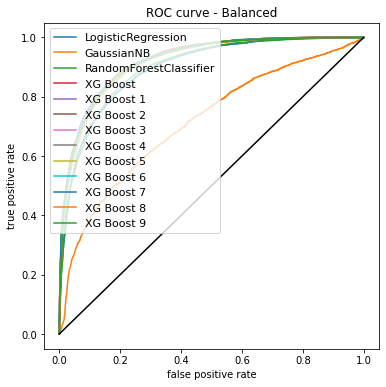

In [ ]:
index_split = int(len(pusa_sampled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

models_report_bal, conf_matrix_bal, clfs_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [ ]:
models_report_bal['train']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.659484,0.910225,0.819402,0.845500,0.832246,Balanced
1,GaussianNB,0.292331,0.717122,0.604669,0.799407,0.688533,Balanced
2,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,Balanced
3,XG Boost,0.730201,0.943126,0.856040,0.877547,0.866660,Balanced
4,XG Boost 1,0.732295,0.943188,0.858833,0.876162,0.867411,Balanced
5,XG Boost 2,0.698656,0.930611,0.838642,0.864688,0.851466,Balanced
6,XG Boost 3,0.702490,0.929451,0.842664,0.863501,0.852956,Balanced
7,XG Boost 4,0.718962,0.937133,0.849798,0.872997,0.861241,Balanced
8,XG Boost 5,0.696186,0.929093,0.839052,0.861128,0.849946,Balanced
9,XG Boost 6,0.715108,0.936304,0.849787,0.868447,0.859016,Balanced


In [ ]:
models_report_bal['test']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.622813,0.895883,0.812317,0.828184,0.820174,Balanced
1,GaussianNB,0.276516,0.713173,0.617638,0.785928,0.691694,Balanced
2,RandomForestClassifier,0.632997,0.897915,0.834677,0.805063,0.819602,Balanced
3,XG Boost,0.684356,0.923845,0.845469,0.851704,0.848575,Balanced
4,XG Boost 1,0.680689,0.922781,0.845878,0.846721,0.846299,Balanced
5,XG Boost 2,0.670912,0.918367,0.839509,0.844529,0.842011,Balanced
6,XG Boost 3,0.669324,0.917505,0.840877,0.840542,0.840710,Balanced
7,XG Boost 4,0.680466,0.920980,0.845297,0.847319,0.846307,Balanced
8,XG Boost 5,0.668234,0.917586,0.838690,0.842535,0.840609,Balanced
9,XG Boost 6,0.680275,0.921243,0.845679,0.846522,0.846100,Balanced


In [ ]:
conf_matrix_bal['XG Boost']

Predicted,0,1
True,,
0,3880,781
1,744,4273


## QII
upload qii_lite.py

In [ ]:
!python --version

Python 3.7.12


In [ ]:
def shapley_influence(cls, x_individual, X_test, columns, column_groups=None):
    p_samples = 600
    s_samples = 600

    def v(S, x, X_inter):
        x_rep = np.tile(x, (p_samples, 1))
        for f in S:
            x_rep[:, f] = X_inter[:, f]
        #p = ((cls.predict(x_rep) == y0)*1.).mean()
        p = ((cls.predict(x_rep) == 1)*1.).mean()
        return (p, x_rep)

    #min_i = np.argmin(sum_local_influence)
    y0 = cls.predict(x_individual)
    print(y0)
    b = np.random.randint(0, X_test.shape[0], p_samples)
    X_sample = X_test[b, :]
    f_columns = columns
    if (column_groups != None):
        sup_ind = column_groups
    else:
        sup_ind = {column: [columns.index(column)] for column in columns}
        super_indices = sup_ind.keys()

    shapley = dict.fromkeys(super_indices, 0)

    for sample in range(0, s_samples):
        perm = np.random.permutation(len(super_indices))
        for i in range(0, len(super_indices)):
            # Choose a random subset and get string indices by flattening
            #  excluding si
            si = super_indices[perm[i]]
            S_m_si = sum([sup_ind[super_indices[perm[j]]] for j in range(0, i)], [])
            #translate into integer indices
            ls_m_si = S_m_si
            #repeat x_individual_rep
            (p_S, X_S) = v(ls_m_si, x_individual, X_sample)
            #also intervene on s_i
            ls_si = sup_ind[si]
            (p_S_si, X_S_si) = v(ls_m_si + ls_si, x_individual, X_sample)
            shapley[si] = shapley[si] - (p_S_si - p_S)/s_samples

    return shapley


In [ ]:
def random_intervene_pop(X, X_pop, cols):
    """ Randomly intervene on a a set of columns of X. """

    m = X.shape[0]
    n = X_pop.shape[0]
    #order = np.random.permutation(range(n))
    order = np.random.randint(n, size=m)
    X_int = np.array(X)
    for c in cols:
        X_int[:, c] = X_pop[order, c]
    return X_int

In [ ]:
def average_local_influence(cls, X, X_pop, columns, column_groups=None):
    average_local_inf = {}
    iters = 10
    f_columns = columns
    if (column_groups != None):
        sup_ind = column_groups
    else:
        sup_ind = {column: [columns.index(column)] for column in columns}
        super_indices = sup_ind.keys()

    y_pred = cls.predict(X)
    for sf in sup_ind:
        local_influence = np.zeros(y_pred.shape[0])
        ls = sup_ind[sf]
        for i in range(0, iters):
            X_inter = random_intervene_pop(X, X_pop, ls)
            y_pred_inter = cls.predict(X_inter)
            local_influence = local_influence + (y_pred == y_pred_inter)*1.

        average_local_inf[sf] = 1 - (local_influence/iters).mean()
        #print('Influence %s: %.3f' % (sf, average_local_inf[sf]))
    return average_local_inf

In [ ]:
# import qii_lite
import pandas

In [ ]:
# from numba import jit, njit, vectorize, cuda

import scipy.special as special
# @cuda.jit

def v(S, x, X_inter, p_samples, cls):
    x_rep = np.tile(x, (p_samples, 1))
    for f in S:
        x_rep[:, f] = X_inter[:, f]
    #p = ((cls.predict(x_rep) == y0)*1.).mean()
    p = special.logit(cls.predict_proba(x_rep))[:,0].mean()
    return (p, x_rep)


def shapley_influence_score(cls, x_individual, X_test, columns, column_groups=None):
    p_samples = 600
    s_samples = 600

    #min_i = np.argmin(sum_local_influence)

    y0 = cls.predict(x_individual)
    print(y0)
    b = np.random.randint(0, X_test.shape[0], p_samples)
    X_sample = X_test[b, :]
    f_columns = columns
    if (column_groups != None):
        sup_ind = column_groups
    else:
        sup_ind = {column: [columns.index(column)] for column in columns}
        super_indices = sup_ind.keys()


    shapley = dict.fromkeys(super_indices, 0)

    for sample in range(0, s_samples):
        perm = np.random.permutation(len(super_indices))
        for i in range(0, len(super_indices)):
            # Choose a random subset and get string indices by flattening
            #  excluding si

            super_indices_list = list(super_indices) # xiyu edit

            si = super_indices_list[perm[i]] # xiyu edit
            S_m_si = sum([sup_ind[super_indices_list[perm[j]]] for j in range(0, i)], []) # xiyu edit
            #translate into integer indices
            ls_m_si = S_m_si
            #repeat x_individual_rep
            (p_S, X_S) = v(ls_m_si, x_individual, X_sample, p_samples, cls)
            #also intervene on s_i
            ls_si = sup_ind[si]
            (p_S_si, X_S_si) = v(ls_m_si + ls_si, x_individual, X_sample, p_samples, cls)
            shapley[si] = shapley[si] - (p_S_si - p_S)/s_samples

    return shapley

In [ ]:
features = list(pusa_sampled.columns)
print(features)
print(len(features))

['DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ST', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM', 'GCL', 'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'RELSHIPP', 'SCH', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WKWN', 'WRK', 'ANC', 'ANC1P', 'ANC2P', 'DIS', 'DRIVESP', 'ESR', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'MSP', 'NATIVITY', 'OC', 'OCCP', 'PAOC', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACAIAN', 'RACASN', 'RACBLK', 'RACNH', 'RACNUM', 'RACPI', 'RACSOR', 'RACWHT', 'RC', 'WAOB', 'FCITP', 'FCOWP', 'FDDRSP', 'FDEARP', 'FDEYEP', 'FDISP', 'FDOUTP', 'FDPHYP', 'FDREMP', 'FENGP', 'FESRP', 'FFERP', 'FFODP', 'FHICOVP', 'FHIMRKSP', 'FHINS1P', 'FHINS2P', 'FHINS3P', 'FHINS4P', 'FHINS5P', 'FHINS6P', 'FHINS7P', 'FJWTRNSP', 'FLANXP', 'FMARP', '

In [ ]:
# import torch
# import os
# import sys
# from tqdm import tqdm
# from numba import jit, njit, vectorize, cuda

# cuda = torch.cuda.is_available()
# device = torch.device("cuda" if cuda else "cpu")
# num_workers = 8 if cuda else 0
# print('Cuda = ', cuda, 'num of workers =', num_workers, "system version = ", sys.version)

Cuda =  True num of workers = 8 system version =  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [ ]:
# !find / -iname 'libdevice'
# !find / -iname 'libnvvm.so'

/usr/local/lib/python3.7/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-11.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so


In [ ]:
# X_test_tensor = torch.tensor(X_test).to(device)
# features_tensor = torch.tensor(features).to(device)
# clf = clfs_bal['XG Boost 9']
# clf = torch.tensor(clf).to(device)

ValueError: ignored

In [ ]:
# shapleys_df.to_csv('shapleys_df150_2000_20.csv')
# !cp shapleys_df150_2000_20.csv "/content"

cp: 'shapleys_df150_2000_20.csv' and '/content/shapleys_df150_2000_20.csv' are the same file


In [ ]:
from tqdm import tqdm

use_stored = False
clf = clfs_bal['XG Boost']
if (use_stored):
    shapleys_df = pandas.read_csv('shapleys_1141_scores_xgboost.csv', index_col=0)
    X_test = np.array(pandas.read_csv('test_1141_scores_xgboost.csv', index_col=0))
    raw_data = pandas.read_csv('rawdata_1141_scores_xgboost.csv', index_col=0)
else:
    clf = clfs_bal['XG Boost']
    shapleys_all = {}
    for i in tqdm(range(40)):
        shapleys_all[i] = shapley_influence_score(clf, np.array([X_test[i]]), X_test, features)
    shapleys_df = pd.DataFrame.from_dict(shapleys_all, orient='index')

  0%|          | 0/40 [00:00<?, ?it/s]

[0]


  2%|▎         | 1/40 [14:43<9:34:29, 883.83s/it]

[1]


  5%|▌         | 2/40 [29:39<9:24:20, 891.05s/it]

[1]


  8%|▊         | 3/40 [44:32<9:09:56, 891.79s/it]

[1]


 10%|█         | 4/40 [59:26<8:55:28, 892.45s/it]

[0]


 12%|█▎        | 5/40 [1:14:04<8:37:35, 887.29s/it]

[0]


 15%|█▌        | 6/40 [1:29:04<8:25:22, 891.84s/it]

[1]


 18%|█▊        | 7/40 [1:44:03<8:11:39, 893.92s/it]

[0]


 20%|██        | 8/40 [1:58:41<7:54:03, 888.86s/it]

[1]


 22%|██▎       | 9/40 [2:13:32<7:39:37, 889.60s/it]

[0]


 25%|██▌       | 10/40 [2:29:06<7:31:36, 903.21s/it]

[0]


 28%|██▊       | 11/40 [2:43:58<7:15:01, 900.06s/it]

[1]


 30%|███       | 12/40 [2:59:12<7:01:58, 904.23s/it]

[0]


 32%|███▎      | 13/40 [3:14:19<6:47:19, 905.15s/it]

[1]


 35%|███▌      | 14/40 [3:29:18<6:31:18, 903.03s/it]

[1]


 38%|███▊      | 15/40 [3:44:11<6:14:59, 900.00s/it]

[1]


 40%|████      | 16/40 [3:59:26<6:01:49, 904.55s/it]

[0]


 42%|████▎     | 17/40 [4:14:45<5:48:24, 908.91s/it]

[1]


 45%|████▌     | 18/40 [4:30:06<5:34:38, 912.68s/it]

[0]


 48%|████▊     | 19/40 [4:44:58<5:17:17, 906.53s/it]

[1]


 50%|█████     | 20/40 [4:59:52<5:00:51, 902.57s/it]

[0]


 52%|█████▎    | 21/40 [5:15:02<4:46:32, 904.87s/it]

[1]


 55%|█████▌    | 22/40 [5:30:15<4:32:10, 907.22s/it]

[1]


 57%|█████▊    | 23/40 [5:45:31<4:17:49, 909.96s/it]

[0]


 60%|██████    | 24/40 [6:00:52<4:03:31, 913.20s/it]

[1]


 62%|██████▎   | 25/40 [6:16:13<3:48:53, 915.58s/it]

[0]


 65%|██████▌   | 26/40 [6:31:21<3:33:07, 913.40s/it]

[1]


 68%|██████▊   | 27/40 [6:46:39<3:18:11, 914.70s/it]

[0]


 70%|███████   | 28/40 [7:01:59<3:03:16, 916.37s/it]

[1]


 72%|███████▎  | 29/40 [7:17:15<2:47:59, 916.30s/it]

[1]


 75%|███████▌  | 30/40 [7:32:32<2:32:43, 916.38s/it]

[1]


 78%|███████▊  | 31/40 [7:47:32<2:16:43, 911.53s/it]

[0]


 80%|████████  | 32/40 [8:02:23<2:00:41, 905.24s/it]

[1]


 82%|████████▎ | 33/40 [8:17:45<1:46:13, 910.46s/it]

[0]


 85%|████████▌ | 34/40 [8:33:03<1:31:15, 912.63s/it]

[1]


 88%|████████▊ | 35/40 [8:48:13<1:15:59, 911.81s/it]

[1]


 90%|█████████ | 36/40 [9:03:30<1:00:53, 913.38s/it]

[0]


 92%|█████████▎| 37/40 [9:18:46<45:42, 914.11s/it]  

[1]


 95%|█████████▌| 38/40 [9:34:13<30:35, 917.95s/it]

[0]


 98%|█████████▊| 39/40 [9:49:18<15:14, 914.11s/it]

[0]


100%|██████████| 40/40 [10:04:35<00:00, 906.88s/it]


In [ ]:
use_stored = False
clf = clfs_bal['XG Boost 9']
if (use_stored):
    shapleys_df = pandas.read_csv('shapleys_1141_scores_xgboost.csv', index_col=0)
    X_test = np.array(pandas.read_csv('test_1141_scores_xgboost.csv', index_col=0))
    raw_data = pandas.read_csv('rawdata_1141_scores_xgboost.csv', index_col=0)
else:
    clf = clfs_bal['XG Boost 9']
    shapleys_all = {}
    for i in tqdm(range(150)):
        shapleys_all[i] = shapley_influence_score(clf, np.array([X_test[i]]), X_test[:2000], features[:20])
    shapleys_df = pd.DataFrame.from_dict(shapleys_all, orient='index')

  0%|          | 0/150 [00:00<?, ?it/s]

here1
[0]
here2


  1%|          | 1/150 [02:41<6:40:36, 161.32s/it]

here1
[1]
here2


  1%|▏         | 2/150 [05:56<7:26:56, 181.19s/it]

here1
[1]
here2


  2%|▏         | 3/150 [09:01<7:28:01, 182.87s/it]

here1
[1]
here2


  3%|▎         | 4/150 [11:58<7:19:06, 180.46s/it]

here1
[0]
here2


  3%|▎         | 5/150 [14:35<6:55:53, 172.09s/it]

here1
[0]
here2


  4%|▍         | 6/150 [17:15<6:43:30, 168.13s/it]

here1
[1]
here2


  5%|▍         | 7/150 [20:16<6:50:28, 172.23s/it]

here1
[0]
here2


  5%|▌         | 8/150 [22:56<6:38:07, 168.22s/it]

here1
[1]
here2


  6%|▌         | 9/150 [25:40<6:32:37, 167.08s/it]

here1
[0]
here2


  7%|▋         | 10/150 [28:46<6:43:02, 172.73s/it]

here1
[0]
here2


  7%|▋         | 11/150 [31:19<6:26:20, 166.77s/it]

here1
[1]
here2


  8%|▊         | 12/150 [34:16<6:30:49, 169.93s/it]

here1
[0]
here2


  9%|▊         | 13/150 [36:57<6:21:49, 167.23s/it]

here1
[1]
here2


  9%|▉         | 14/150 [39:46<6:20:29, 167.87s/it]

here1
[1]
here2


 10%|█         | 15/150 [42:42<6:23:17, 170.35s/it]

here1
[1]
here2


 11%|█         | 16/150 [45:49<6:31:25, 175.26s/it]

here1
[0]
here2


 11%|█▏        | 17/150 [48:30<6:18:54, 170.93s/it]

here1
[1]
here2


 12%|█▏        | 18/150 [51:39<6:28:14, 176.47s/it]

here1
[0]
here2


 13%|█▎        | 19/150 [54:13<6:10:04, 169.50s/it]

here1
[0]
here2


 13%|█▎        | 20/150 [56:54<6:02:13, 167.18s/it]

here1
[0]
here2


 14%|█▍        | 21/150 [1:00:05<6:14:55, 174.38s/it]

here1
[1]
here2


 15%|█▍        | 22/150 [1:03:03<6:13:52, 175.25s/it]

here1
[1]
here2


 15%|█▌        | 23/150 [1:05:50<6:06:06, 172.97s/it]

here1
[0]
here2


 16%|█▌        | 24/150 [1:08:57<6:11:59, 177.14s/it]

here1
[1]
here2


 17%|█▋        | 25/150 [1:11:54<6:08:58, 177.11s/it]

here1
[0]
here2


 17%|█▋        | 26/150 [1:14:41<5:59:34, 173.99s/it]

here1
[1]
here2


 18%|█▊        | 27/150 [1:17:34<5:56:22, 173.84s/it]

here1
[0]
here2


 19%|█▊        | 28/150 [1:20:38<5:59:25, 176.76s/it]

here1
[1]
here2


 19%|█▉        | 29/150 [1:23:29<5:52:50, 174.96s/it]

here1
[1]
here2


 20%|██        | 30/150 [1:26:20<5:47:37, 173.81s/it]

here1
[1]
here2


 21%|██        | 31/150 [1:29:19<5:47:37, 175.27s/it]

here1
[0]
here2


 21%|██▏       | 32/150 [1:31:59<5:35:51, 170.77s/it]

here1
[1]
here2


 22%|██▏       | 33/150 [1:35:03<5:40:44, 174.74s/it]

here1
[0]
here2


 23%|██▎       | 34/150 [1:38:08<5:43:53, 177.88s/it]

here1
[1]
here2


 23%|██▎       | 35/150 [1:41:15<5:46:14, 180.64s/it]

here1
[1]
here2


 24%|██▍       | 36/150 [1:44:15<5:42:53, 180.47s/it]

here1
[0]
here2


 25%|██▍       | 37/150 [1:47:16<5:39:53, 180.47s/it]

here1
[1]
here2


 25%|██▌       | 38/150 [1:50:21<5:39:49, 182.05s/it]

here1
[0]
here2


 26%|██▌       | 39/150 [1:53:17<5:33:10, 180.09s/it]

here1
[0]
here2


 27%|██▋       | 40/150 [1:56:04<5:22:42, 176.02s/it]

here1
[0]
here2


 27%|██▋       | 41/150 [1:58:44<5:11:04, 171.24s/it]

here1
[1]
here2


 28%|██▊       | 42/150 [2:01:46<5:14:00, 174.45s/it]

here1
[0]
here2


 29%|██▊       | 43/150 [2:04:38<5:09:47, 173.71s/it]

here1
[1]
here2


 29%|██▉       | 44/150 [2:07:35<5:08:49, 174.81s/it]

here1
[1]
here2


 30%|███       | 45/150 [2:10:23<5:02:28, 172.84s/it]

here1
[0]
here2


 31%|███       | 46/150 [2:13:16<4:59:26, 172.75s/it]

here1
[0]
here2


 31%|███▏      | 47/150 [2:15:54<4:49:01, 168.36s/it]

here1
[1]
here2


 32%|███▏      | 48/150 [2:18:46<4:48:07, 169.49s/it]

here1
[1]
here2


 33%|███▎      | 49/150 [2:21:31<4:42:59, 168.11s/it]

here1
[1]
here2


 33%|███▎      | 50/150 [2:24:20<4:40:30, 168.30s/it]

here1
[1]
here2


 34%|███▍      | 51/150 [2:27:16<4:41:46, 170.78s/it]

here1
[1]
here2


 35%|███▍      | 52/150 [2:30:14<4:42:09, 172.75s/it]

here1
[1]
here2


 35%|███▌      | 53/150 [2:33:05<4:38:32, 172.29s/it]

here1
[0]
here2


 36%|███▌      | 54/150 [2:35:44<4:29:16, 168.29s/it]

here1
[0]
here2


 37%|███▋      | 55/150 [2:38:25<4:23:03, 166.15s/it]

here1
[0]
here2


 37%|███▋      | 56/150 [2:41:03<4:16:27, 163.70s/it]

here1
[1]
here2


 38%|███▊      | 57/150 [2:43:48<4:14:12, 164.00s/it]

here1
[0]
here2


 39%|███▊      | 58/150 [2:46:34<4:12:32, 164.70s/it]

here1
[0]
here2


 39%|███▉      | 59/150 [2:49:16<4:08:32, 163.87s/it]

here1
[1]
here2


 40%|████      | 60/150 [2:52:06<4:08:37, 165.75s/it]

here1
[0]
here2


 41%|████      | 61/150 [2:54:41<4:00:57, 162.44s/it]

here1
[0]
here2


 41%|████▏     | 62/150 [2:57:30<4:01:17, 164.51s/it]

here1
[0]
here2


 42%|████▏     | 63/150 [3:00:15<3:58:47, 164.68s/it]

here1
[0]
here2


 43%|████▎     | 64/150 [3:02:58<3:55:18, 164.17s/it]

here1
[1]
here2


 43%|████▎     | 65/150 [3:05:49<3:55:31, 166.26s/it]

here1
[0]
here2


 44%|████▍     | 66/150 [3:08:40<3:54:50, 167.75s/it]

here1
[1]
here2


 45%|████▍     | 67/150 [3:11:37<3:55:38, 170.34s/it]

here1
[0]
here2


 45%|████▌     | 68/150 [3:14:36<3:56:20, 172.93s/it]

here1
[0]
here2


 46%|████▌     | 69/150 [3:17:26<3:52:31, 172.24s/it]

here1
[1]
here2


 47%|████▋     | 70/150 [3:20:32<3:55:10, 176.38s/it]

here1
[1]
here2


 47%|████▋     | 71/150 [3:23:33<3:53:48, 177.57s/it]

here1
[1]
here2


 48%|████▊     | 72/150 [3:26:35<3:52:39, 178.96s/it]

here1
[1]
here2


 49%|████▊     | 73/150 [3:29:28<3:47:19, 177.13s/it]

here1
[1]
here2


 49%|████▉     | 74/150 [3:32:32<3:47:10, 179.35s/it]

here1
[0]
here2


 50%|█████     | 75/150 [3:35:13<3:37:14, 173.79s/it]

here1
[1]
here2


 51%|█████     | 76/150 [3:38:02<3:32:39, 172.43s/it]

here1
[1]
here2


 51%|█████▏    | 77/150 [3:41:12<3:35:57, 177.50s/it]

here1
[1]
here2


 52%|█████▏    | 78/150 [3:44:15<3:35:12, 179.34s/it]

here1
[1]
here2


 53%|█████▎    | 79/150 [3:47:20<3:34:09, 180.97s/it]

here1
[1]
here2


 53%|█████▎    | 80/150 [3:50:12<3:27:59, 178.27s/it]

here1
[1]
here2


 54%|█████▍    | 81/150 [3:53:13<3:25:56, 179.08s/it]

here1
[0]
here2


 55%|█████▍    | 82/150 [3:56:01<3:19:09, 175.73s/it]

here1
[1]
here2


 55%|█████▌    | 83/150 [3:59:11<3:21:03, 180.05s/it]

here1
[0]
here2


 56%|█████▌    | 84/150 [4:01:48<3:10:31, 173.21s/it]

here1
[1]
here2


 57%|█████▋    | 85/150 [4:04:46<3:09:00, 174.47s/it]

here1
[0]
here2


 57%|█████▋    | 86/150 [4:07:21<2:59:53, 168.65s/it]

here1
[0]
here2


 58%|█████▊    | 87/150 [4:09:57<2:52:58, 164.73s/it]

here1
[1]
here2


 59%|█████▊    | 88/150 [4:12:54<2:54:12, 168.59s/it]

here1
[0]
here2


 59%|█████▉    | 89/150 [4:15:39<2:50:12, 167.41s/it]

here1
[0]
here2


 60%|██████    | 90/150 [4:18:18<2:44:49, 164.83s/it]

here1
[0]
here2


 61%|██████    | 91/150 [4:21:07<2:43:32, 166.32s/it]

here1
[1]
here2


 61%|██████▏   | 92/150 [4:23:56<2:41:22, 166.93s/it]

here1
[0]
here2


 62%|██████▏   | 93/150 [4:26:49<2:40:31, 168.98s/it]

here1
[0]
here2


 63%|██████▎   | 94/150 [4:29:47<2:40:07, 171.57s/it]

here1
[1]
here2


 63%|██████▎   | 95/150 [4:32:47<2:39:26, 173.94s/it]

here1
[0]
here2


 64%|██████▍   | 96/150 [4:35:34<2:34:48, 172.01s/it]

here1
[1]
here2


 65%|██████▍   | 97/150 [4:38:24<2:31:25, 171.42s/it]

here1
[0]
here2


 65%|██████▌   | 98/150 [4:41:35<2:33:41, 177.34s/it]

here1
[1]
here2


 66%|██████▌   | 99/150 [4:44:28<2:29:32, 175.94s/it]

here1
[0]
here2


 67%|██████▋   | 100/150 [4:47:15<2:24:25, 173.32s/it]

here1
[0]
here2


 67%|██████▋   | 101/150 [4:50:17<2:23:36, 175.84s/it]

here1
[1]
here2


 68%|██████▊   | 102/150 [4:53:17<2:21:35, 176.99s/it]

here1
[0]
here2


 69%|██████▊   | 103/150 [4:55:52<2:13:32, 170.49s/it]

here1
[0]
here2


 69%|██████▉   | 104/150 [4:58:31<2:08:09, 167.17s/it]

here1
[1]
here2


 70%|███████   | 105/150 [5:01:32<2:08:22, 171.17s/it]

here1
[1]
here2


 71%|███████   | 106/150 [5:04:24<2:05:50, 171.60s/it]

here1
[1]
here2


 71%|███████▏  | 107/150 [5:07:21<2:03:57, 172.97s/it]

here1
[1]
here2


 72%|███████▏  | 108/150 [5:10:02<1:58:44, 169.63s/it]

here1
[1]
here2


 73%|███████▎  | 109/150 [5:12:56<1:56:48, 170.94s/it]

here1
[0]
here2


 73%|███████▎  | 110/150 [5:15:35<1:51:27, 167.18s/it]

here1
[0]
here2


 74%|███████▍  | 111/150 [5:18:14<1:47:01, 164.65s/it]

here1
[0]
here2


 75%|███████▍  | 112/150 [5:20:57<1:44:07, 164.40s/it]

here1
[0]
here2


 75%|███████▌  | 113/150 [5:23:41<1:41:19, 164.32s/it]

here1
[0]
here2


 76%|███████▌  | 114/150 [5:26:33<1:39:52, 166.45s/it]

here1
[0]
here2


 77%|███████▋  | 115/150 [5:29:12<1:35:45, 164.17s/it]

here1
[1]
here2


 77%|███████▋  | 116/150 [5:32:01<1:33:56, 165.78s/it]

here1
[1]
here2


 78%|███████▊  | 117/150 [5:34:40<1:30:02, 163.70s/it]

here1
[0]
here2


 79%|███████▊  | 118/150 [5:37:41<1:29:59, 168.72s/it]

here1
[1]
here2


 79%|███████▉  | 119/150 [5:40:27<1:26:50, 168.10s/it]

here1
[0]
here2


 80%|████████  | 120/150 [5:43:02<1:22:04, 164.14s/it]

here1
[1]
here2


 81%|████████  | 121/150 [5:46:05<1:22:00, 169.68s/it]

here1
[1]
here2


 81%|████████▏ | 122/150 [5:48:50<1:18:32, 168.32s/it]

here1
[1]
here2


 82%|████████▏ | 123/150 [5:51:36<1:15:28, 167.74s/it]

here1
[0]
here2


 83%|████████▎ | 124/150 [5:54:11<1:10:56, 163.71s/it]

here1
[1]
here2


 83%|████████▎ | 125/150 [5:57:12<1:10:27, 169.10s/it]

here1
[1]
here2


 84%|████████▍ | 126/150 [6:00:05<1:08:03, 170.16s/it]

here1
[1]
here2


 85%|████████▍ | 127/150 [6:02:52<1:04:54, 169.32s/it]

here1
[1]
here2


 85%|████████▌ | 128/150 [6:05:38<1:01:39, 168.15s/it]

here1
[1]
here2


 86%|████████▌ | 129/150 [6:08:26<58:54, 168.29s/it]  

here1
[0]
here2


 87%|████████▋ | 130/150 [6:11:31<57:43, 173.19s/it]

here1
[0]
here2


 87%|████████▋ | 131/150 [6:14:10<53:29, 168.92s/it]

here1
[0]
here2


 88%|████████▊ | 132/150 [6:16:56<50:23, 167.98s/it]

here1
[1]
here2


 89%|████████▊ | 133/150 [6:20:05<49:24, 174.40s/it]

here1
[1]
here2


 89%|████████▉ | 134/150 [6:22:53<45:59, 172.47s/it]

here1
[0]
here2


 90%|█████████ | 135/150 [6:25:35<42:21, 169.42s/it]

here1
[0]
here2


 91%|█████████ | 136/150 [6:28:38<40:28, 173.49s/it]

here1
[1]
here2


 91%|█████████▏| 137/150 [6:31:23<37:02, 170.94s/it]

here1
[0]
here2


 92%|█████████▏| 138/150 [6:34:14<34:09, 170.76s/it]

here1
[1]
here2


 93%|█████████▎| 139/150 [6:36:56<30:49, 168.15s/it]

here1
[0]
here2


 93%|█████████▎| 140/150 [6:39:36<27:39, 165.93s/it]

here1
[0]
here2


 94%|█████████▍| 141/150 [6:42:07<24:10, 161.21s/it]

here1
[0]
here2


 95%|█████████▍| 142/150 [6:44:53<21:41, 162.68s/it]

here1
[1]
here2


 95%|█████████▌| 143/150 [6:48:02<19:55, 170.76s/it]

here1
[1]
here2


 96%|█████████▌| 144/150 [6:50:47<16:54, 169.05s/it]

here1
[0]
here2


 97%|█████████▋| 145/150 [6:53:18<13:37, 163.60s/it]

here1
[0]
here2


 97%|█████████▋| 146/150 [6:56:06<10:59, 164.87s/it]

here1
[1]
here2


 98%|█████████▊| 147/150 [6:58:45<08:09, 163.03s/it]

here1
[1]
here2


 99%|█████████▊| 148/150 [7:01:27<05:25, 162.64s/it]

here1
[0]
here2


 99%|█████████▉| 149/150 [7:04:07<02:41, 161.92s/it]

here1
[1]
here2


100%|██████████| 150/150 [7:07:01<00:00, 170.81s/it]


In [ ]:

# X_test = X_test.to(device)
# features = features.to(device)
# clf = clf.to(device)
# shapley_influence_score = shapley_influence_score().to(device)

use_stored = False
clf = clfs_bal['XG Boost 9']
if (use_stored):
    shapleys_df = pandas.read_csv('shapleys_1141_scores_xgboost.csv', index_col=0)
    X_test = np.array(pandas.read_csv('test_1141_scores_xgboost.csv', index_col=0))
    raw_data = pandas.read_csv('rawdata_1141_scores_xgboost.csv', index_col=0)
else:
    clf = clfs_bal['XG Boost 9']
    shapleys_all = {}
    for i in tqdm(range(2000)):
        shapleys_all[i] = shapley_influence_score(clf, np.array([X_test[i]]), X_test[:2000], features[:20])
    shapleys_df = pd.DataFrame.from_dict(shapleys_all, orient='index')
    

  0%|          | 0/2000 [00:00<?, ?it/s]

here1
[0]
here2


ValueError: ignored

In [ ]:
X_test

array([[-0.20157368,  0.68068605,  2.14775218, ..., -0.01245081,
        -0.00718811, -0.01016578],
       [-1.80053213, -0.74175819, -0.91000999, ..., -0.01245081,
        -0.00718811, -0.01016578],
       [-0.20157368, -0.74175819, -0.71030177, ..., -0.01245081,
        -0.00718811, -0.01016578],
       ...,
       [ 1.39738476,  2.10313029,  0.241386  , ..., -0.01245081,
        -0.00718811, -0.01016578],
       [ 0.19816593,  0.68068605, -0.94323932, ..., -0.01245081,
        -0.00718811, -0.01016578],
       [-1.80053213,  0.68068605, -0.37834085, ..., -0.01245081,
        -0.00718811, -0.01016578]])

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
#model = KMeans(3)
model1 = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward')
clust_labels1 = model1.fit_predict(shapleys_df)

In [ ]:
clust_labels1.max()

1

In [ ]:
model2 = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
clust_labels2 = model2.fit_predict(shapleys_df)

In [ ]:
clust_labels2.max()

11

In [ ]:
model3 = KMeans(5)
clust_labels3 = model3.fit_predict(shapleys_df)

In [ ]:
clust_labels3.max()

4

In [ ]:
from sklearn.cluster import DBSCAN
model4 = DBSCAN(eps=0.25, min_samples=5)
clust_labels4 = model4.fit_predict(shapleys_df)

In [ ]:
clust_labels4.max()
clust_labels=clust_labels4

In [ ]:
[(clust_labels4 == i).sum() for i in range(-1,clust_labels4.max()+1)]

[19, 131]

In [ ]:
from sklearn import tree
explainer = tree.DecisionTreeClassifier(max_leaf_nodes=8)
explainer.fit(shapleys_df, clust_labels)

DecisionTreeClassifier(max_leaf_nodes=8)

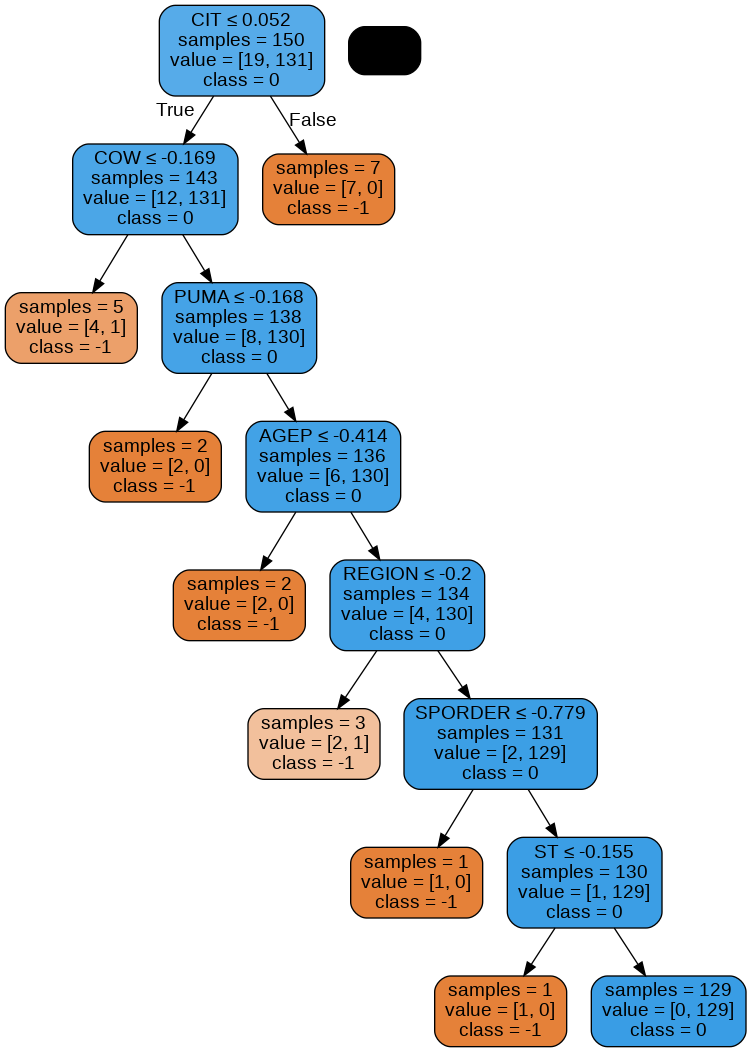

In [ ]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(explainer, out_file=dot_data,
                feature_names=list(shapleys_df),
                filled=True, rounded=True, impurity=False,
                special_characters=True, class_names=['-1','0','1','2','3','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn import tree
mapper = tree.DecisionTreeClassifier(max_leaf_nodes=8)
mapper.fit(np.array(X_test)[0:150,:], clust_labels)

DecisionTreeClassifier(max_leaf_nodes=8)

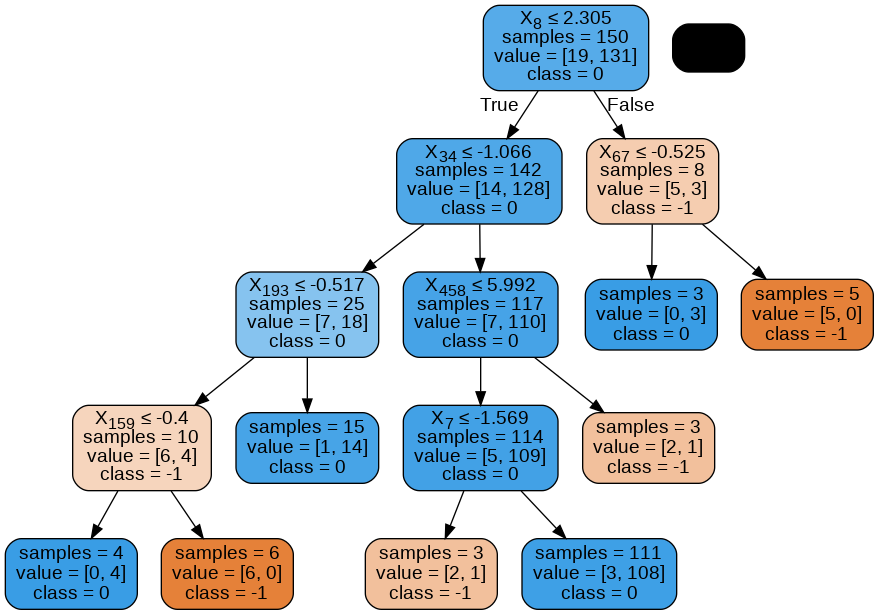

In [ ]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(mapper, out_file=dot_data,  
                filled=True, rounded=True, impurity=False,
                special_characters=True,
                #feature_names=list(X.columns), 
                class_names=['-1','0','1','2','3','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

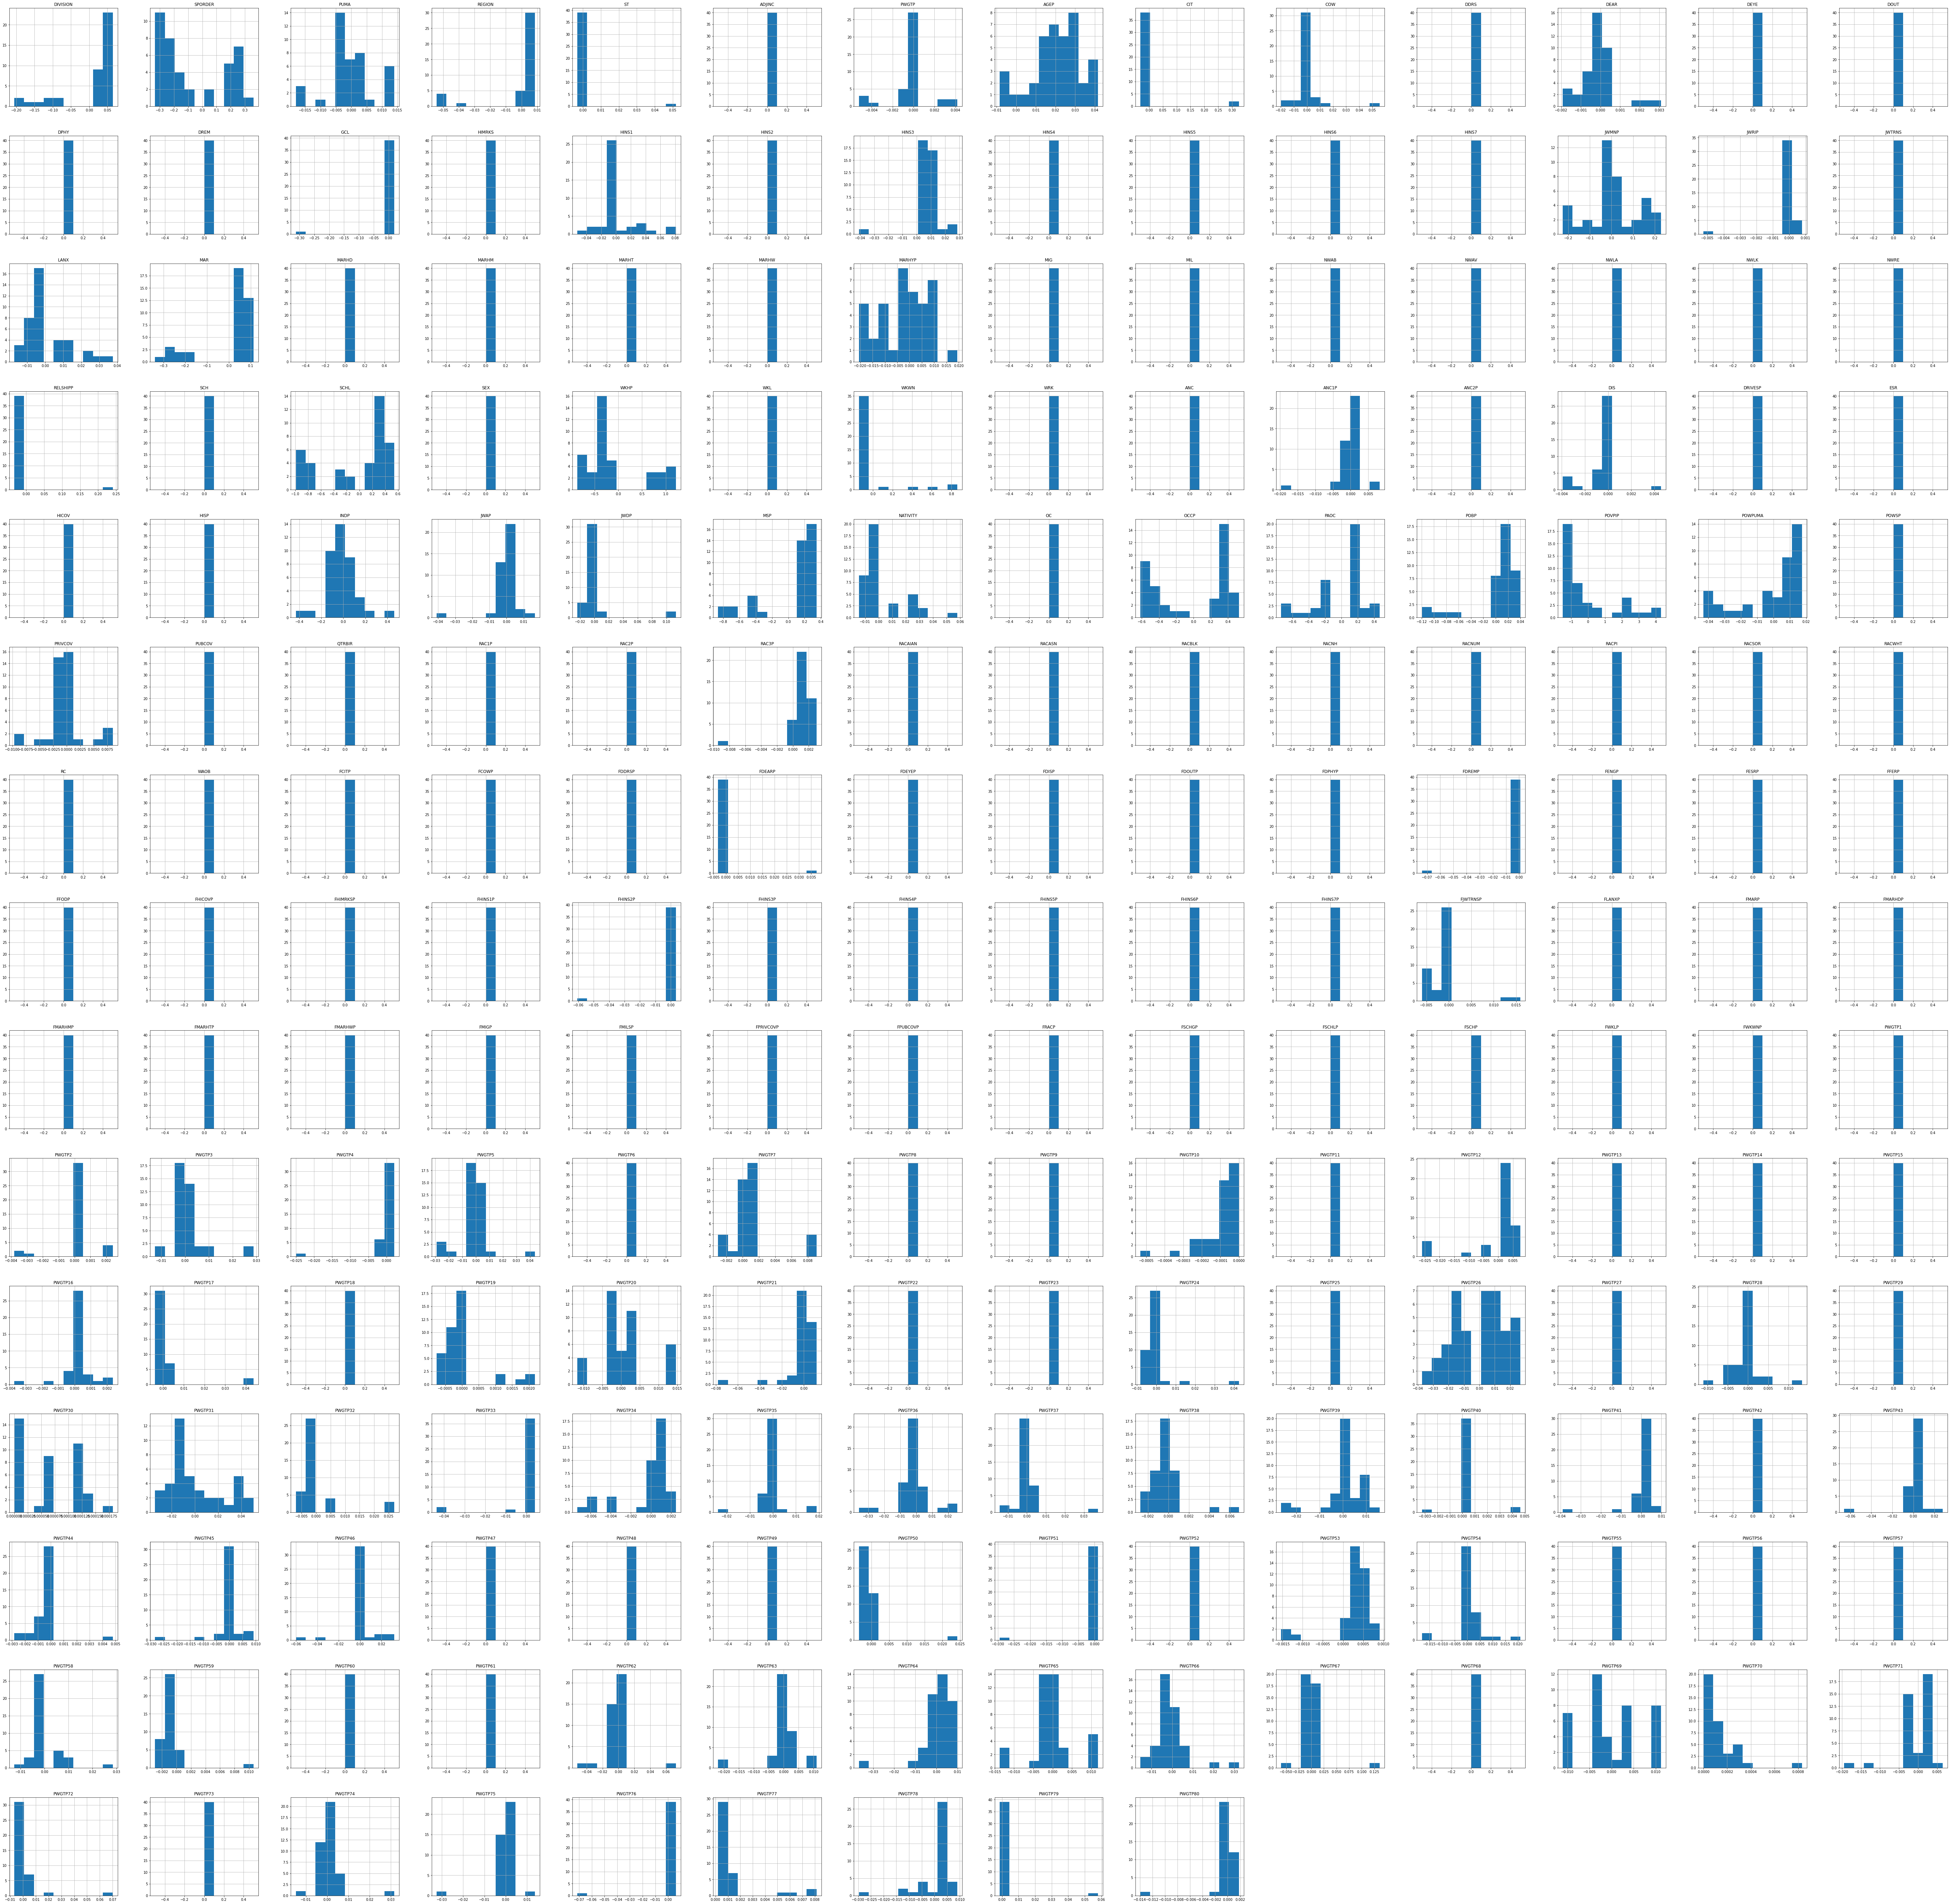

In [ ]:
shapleys_df.hist(figsize=(100,100))
plt.show()

In [ ]:

shapleys_df.to_csv('shapleys_df40_poor.csv')
!cp shapleys_df40_poor.csv "/content"

cp: 'shapleys_df40_poor.csv' and '/content/shapleys_df40_poor.csv' are the same file


In [ ]:
from sklearn.cluster import DBSCAN
model4 = DBSCAN(eps=0.25, min_samples=5)
clust_labels4 = model4.fit_predict(shapleys_df)

In [ ]:
import scipy.special as special
X_test_1141 = X_test[0:400,:]
for i in range(0, 4):
    score_series_i = pd.Series(special.logit(clf.predict_proba(X_test_1141[clust_labels4 == i])[:,1]))
    score_series_i.plot(kind='kde',figsize=(12,5), alpha=0.5, label='Cluster '+str(i))
plt.legend(loc='upper left')
plt.show()

IndexError: ignored